# New FTIR Data Analysis - BTY Alucone As-Deposited

This notebook analyzes the new FTIR data from 2025-07-21 for BTY Alucone as-deposited samples.
The new data should be more accurate than previous measurements.

## Data Files:
- `Alucone_ad_powder.JDX`
- `Alucone_ad_powder_2.JDX`

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
from typing import Dict, List, Tuple

# Add project root to path
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))

# Import shared utilities
from shared.utils.plot_styles import set_plot_style
from shared.utils.config import *
from shared.utils.helpers import save_figure, create_figure

# Import jcamp for JDX file reading (install with: pip install jcamp)
try:
    import jcamp
    print("✅ jcamp library available for JDX file reading")
except ImportError:
    print("❌ jcamp library not found. Installing...")
    import subprocess
    import sys
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'jcamp'])
    import jcamp
    print("✅ jcamp library installed and imported")

# Set plot style
set_plot_style()

# Set matplotlib backend for interactive plots
# Try different backends until one works
try:
    %matplotlib inline
    print("Using inline backend for matplotlib")
except:
    print("Setting up matplotlib for static plots")

print("📊 Notebook ready for FTIR analysis!")

❌ jcamp library not found. Installing...
✅ jcamp library installed and imported
Using inline backend for matplotlib
📊 Notebook ready for FTIR analysis!


## Functions for JDX File Reading

In [2]:
def read_jdx_file(filepath: str) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """
    Read a JDX (JCAMP-DX) FTIR file using the jcamp library.
    
    This is much more reliable than manual parsing and handles all JDX format complexities.
    
    Returns:
        wavenumbers (np.ndarray): Wavenumber values in cm⁻¹
        intensities (np.ndarray): Intensity/absorbance values
        metadata (dict): Metadata from file header including instrument info
    """
    # Read JDX file using jcamp library
    data = jcamp.jcamp_readfile(filepath)
    
    # Extract spectral data
    wavenumbers = np.array(data['x'])
    intensities = np.array(data['y'])
    
    # Extract metadata (remove x, y arrays from metadata dict for cleaner output)
    metadata = {k: v for k, v in data.items() if k not in ['x', 'y']}
    
    # Sort by wavenumber (ascending) if needed
    if len(wavenumbers) > 1 and wavenumbers[0] > wavenumbers[-1]:
        # Data is in descending order, reverse it
        wavenumbers = wavenumbers[::-1]
        intensities = intensities[::-1]
    
    return wavenumbers, intensities, metadata

def normalize_spectrum(intensities: np.ndarray) -> np.ndarray:
    """
    Normalize spectrum to 0-1 range for better visualization and comparison.
    """
    return (intensities - intensities.min()) / (intensities.max() - intensities.min())

def compare_spectra_quality(wn1, int1, wn2, int2, filename1="File 1", filename2="File 2"):
    """
    Compare the quality of two FTIR spectra and recommend which to use.
    """
    print(f"\n📊 Spectrum Quality Comparison")
    print("="*50)
    
    # Resolution comparison
    res1 = np.mean(np.diff(wn1))
    res2 = np.mean(np.diff(wn2))
    print(f"Resolution: {filename1}: {res1:.3f} cm⁻¹/point, {filename2}: {res2:.3f} cm⁻¹/point")
    
    # Signal variation (indicator of peak richness)
    var1 = np.std(int1)
    var2 = np.std(int2)
    print(f"Signal variation: {filename1}: {var1:.6f}, {filename2}: {var2:.6f}")
    
    # Signal-to-noise estimation (baseline stability)
    baseline1 = np.std(int1[:100])  # First 100 points as baseline estimate
    baseline2 = np.std(int2[:100])
    print(f"Baseline stability: {filename1}: {baseline1:.6f}, {filename2}: {baseline2:.6f}")
    
    # Overall recommendation
    score1 = var1 / baseline1 if baseline1 > 0 else 0
    score2 = var2 / baseline2 if baseline2 > 0 else 0
    
    better_file = filename1 if score1 > score2 else filename2
    print(f"\n✅ Recommendation: Use {better_file} (better signal-to-noise ratio)")
    
    return better_file

## Load New FTIR Data

In [3]:
# Load the two new JDX files
data_dir = Path('../data/raw/250721')

file1 = data_dir / 'Alucone_ad_powder.JDX'
file2 = data_dir / 'Alucone_ad_powder_2.JDX'

print("Loading new FTIR data files using jcamp library...")
print(f"File 1: {file1}")
print(f"File 2: {file2}")

try:
    wn1, int1, meta1 = read_jdx_file(str(file1))
    wn2, int2, meta2 = read_jdx_file(str(file2))
    
    print(f"✅ Successfully loaded both files using jcamp")
    print(f"File 1: {len(wn1)} data points, range {wn1.min():.0f}-{wn1.max():.0f} cm⁻¹")
    print(f"File 2: {len(wn2)} data points, range {wn2.min():.0f}-{wn2.max():.0f} cm⁻¹")
    
    # Show key metadata
    print("\n📋 Key Metadata from File 1:")
    metadata_keys = ['title', 'longdate', 'time', 'spectrometer/data system', 'resolution', 'npoints']
    for key in metadata_keys:
        if key in meta1:
            print(f"  {key}: {meta1[key]}")
    
    # Compare spectrum quality
    recommended_file = compare_spectra_quality(
        wn1, int1, wn2, int2, 
        filename1="Alucone_ad_powder.JDX", 
        filename2="Alucone_ad_powder_2.JDX"
    )
            
except Exception as e:
    print(f"❌ Error loading files: {e}")
    print("This might indicate a problem with the JDX files or jcamp installation.")

Loading new FTIR data files using jcamp library...
File 1: ..\data\raw\250721\Alucone_ad_powder.JDX
File 2: ..\data\raw\250721\Alucone_ad_powder_2.JDX
✅ Successfully loaded both files using jcamp
File 1: 7053 data points, range 600-4000 cm⁻¹
File 2: 7053 data points, range 600-4000 cm⁻¹

📋 Key Metadata from File 1:
  title: Mon Jul 21 12:33:27 2025 (GMT-07:00)
  longdate: 2025-07-21 00:00:00
  time: 13:04:59
  spectrometer/data system: Nicolet iS50
  resolution: 4.0
  npoints: 7053

📊 Spectrum Quality Comparison
Resolution: Alucone_ad_powder.JDX: 0.482 cm⁻¹/point, Alucone_ad_powder_2.JDX: 0.482 cm⁻¹/point
Signal variation: Alucone_ad_powder.JDX: 0.030676, Alucone_ad_powder_2.JDX: 0.059721
Baseline stability: Alucone_ad_powder.JDX: 0.002834, Alucone_ad_powder_2.JDX: 0.003711

✅ Recommendation: Use Alucone_ad_powder_2.JDX (better signal-to-noise ratio)


## Plot the New Data

C:\Users\dreec\AppData\Local\Temp\ipykernel_33648\3145380785.py:26: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dreec\AppData\Local\Temp\ipykernel_33648\3145380785.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\dreec\miniconda3\envs\Paper2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


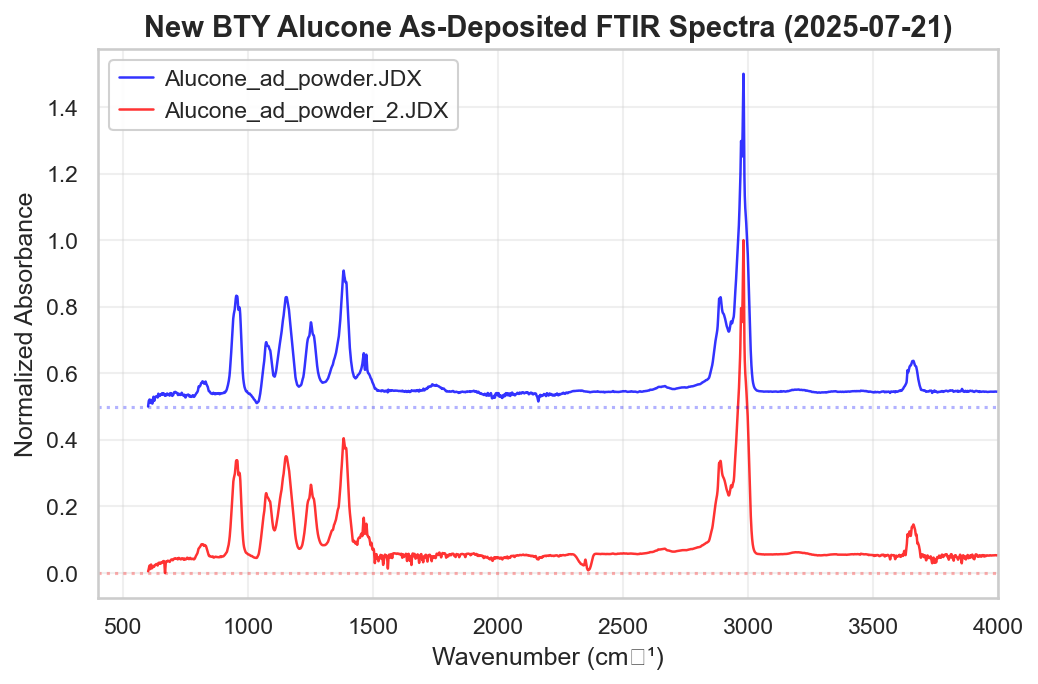


📊 Both new FTIR spectra plotted for comparison
Blue line: First measurement (offset +0.5)
Red line: Second measurement (baseline)


In [4]:
# Create plot of both new spectra
fig, ax = create_figure(width_cm=18, aspect_ratio=3/2)  # Fixed: use aspect_ratio instead of height_cm

# Normalize the data for better comparison
int1_norm = normalize_spectrum(int1)
int2_norm = normalize_spectrum(int2)

# Plot with slight offset for clarity
offset = 0.5
ax.plot(wn1, int1_norm + offset, 'b-', linewidth=1.2, label='Alucone_ad_powder.JDX', alpha=0.8)
ax.plot(wn2, int2_norm, 'r-', linewidth=1.2, label='Alucone_ad_powder_2.JDX', alpha=0.8)

# Add baseline references
ax.axhline(y=offset, color='blue', linestyle=':', alpha=0.3)
ax.axhline(y=0, color='red', linestyle=':', alpha=0.3)

# Formatting
ax.set_xlim(4000, 400)
ax.set_xlabel('Wavenumber (cm⁻¹)', fontsize=12)
ax.set_ylabel('Normalized Absorbance', fontsize=12)
ax.set_title('New BTY Alucone As-Deposited FTIR Spectra (2025-07-21)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_xaxis()  # FTIR convention: high to low wavenumbers

plt.tight_layout()
plt.show()

print("\n📊 Both new FTIR spectra plotted for comparison")
print("Blue line: First measurement (offset +0.5)")
print("Red line: Second measurement (baseline)")

## Load Existing FTIR Data for Comparison

In [5]:
# Load existing processed FTIR data
existing_file = Path('../data/processed/BTYFTIR_Final.xlsx')

if existing_file.exists():
    print(f"Loading existing FTIR data from: {existing_file}")
    
    # Load the Excel file
    existing_data = pd.read_excel(existing_file, header=None)
    existing_data.columns = ['Wavenumber_AsDep', 'Intensity_AsDep', 'Wavenumber_UV', 'Intensity_UV']
    
    # Extract as-deposited data (what we want to compare with new data)
    wn_existing = existing_data['Wavenumber_AsDep'].dropna().values
    int_existing = existing_data['Intensity_AsDep'].dropna().values
    
    print(f"✅ Loaded existing data: {len(wn_existing)} points, range {wn_existing.min():.0f}-{wn_existing.max():.0f} cm⁻¹")
    
    # Normalize existing data
    int_existing_norm = normalize_spectrum(int_existing)
    
else:
    print(f"❌ Existing data file not found: {existing_file}")
    wn_existing = None

Loading existing FTIR data from: ..\data\processed\BTYFTIR_Final.xlsx
✅ Loaded existing data: 7260 points, range 500-4000 cm⁻¹


## Comparison Plot: New vs Existing Data

C:\Users\dreec\AppData\Local\Temp\ipykernel_33648\1486180635.py:48: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dreec\AppData\Local\Temp\ipykernel_33648\1486180635.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\dreec\miniconda3\envs\Paper2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


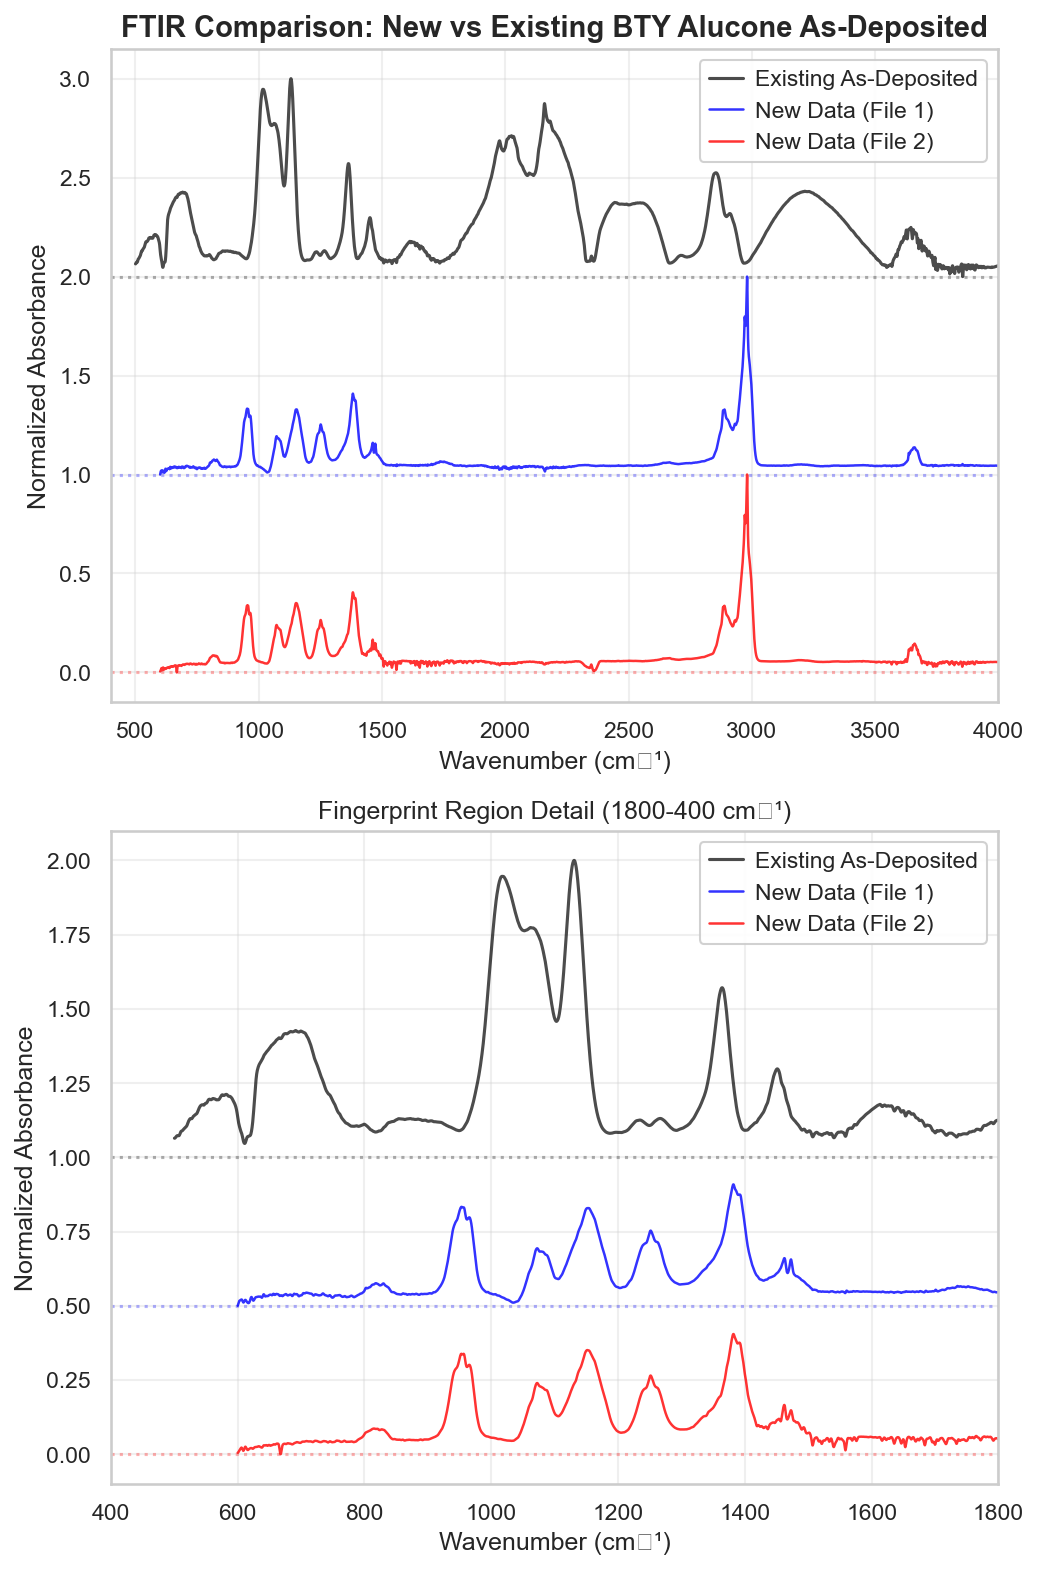


📊 Comparison plot created
• Black line: Existing data (top)
• Blue line: New measurement 1 (middle)
• Red line: New measurement 2 (bottom)
• Bottom panel shows fingerprint region for detailed peak comparison


In [6]:
if wn_existing is not None:
    # Create comparison plot
    fig, (ax1, ax2) = create_figure(rows=2, width_cm=18, aspect_ratio=2/3)  # Fixed: use rows parameter and proper aspect_ratio
    
    # Top plot: All spectra overlaid
    offset1, offset2 = 1.0, 2.0
    
    ax1.plot(wn_existing, int_existing_norm + offset2, 'k-', linewidth=1.5, 
             label='Existing As-Deposited', alpha=0.7)
    ax1.plot(wn1, int1_norm + offset1, 'b-', linewidth=1.2, 
             label='New Data (File 1)', alpha=0.8)
    ax1.plot(wn2, int2_norm, 'r-', linewidth=1.2, 
             label='New Data (File 2)', alpha=0.8)
    
    # Add baseline references
    ax1.axhline(y=offset2, color='black', linestyle=':', alpha=0.3)
    ax1.axhline(y=offset1, color='blue', linestyle=':', alpha=0.3)
    ax1.axhline(y=0, color='red', linestyle=':', alpha=0.3)
    
    ax1.set_xlim(4000, 400)
    ax1.set_xlabel('Wavenumber (cm⁻¹)', fontsize=12)
    ax1.set_ylabel('Normalized Absorbance', fontsize=12)
    ax1.set_title('FTIR Comparison: New vs Existing BTY Alucone As-Deposited', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.invert_xaxis()
    
    # Bottom plot: Focused region (1800-400 cm⁻¹) for better peak comparison
    ax2.plot(wn_existing, int_existing_norm + offset1, 'k-', linewidth=1.5, 
             label='Existing As-Deposited', alpha=0.7)
    ax2.plot(wn1, int1_norm + 0.5, 'b-', linewidth=1.2, 
             label='New Data (File 1)', alpha=0.8)
    ax2.plot(wn2, int2_norm, 'r-', linewidth=1.2, 
             label='New Data (File 2)', alpha=0.8)
    
    ax2.axhline(y=offset1, color='black', linestyle=':', alpha=0.3)
    ax2.axhline(y=0.5, color='blue', linestyle=':', alpha=0.3)
    ax2.axhline(y=0, color='red', linestyle=':', alpha=0.3)
    
    ax2.set_xlim(1800, 400)
    ax2.set_xlabel('Wavenumber (cm⁻¹)', fontsize=12)
    ax2.set_ylabel('Normalized Absorbance', fontsize=12)
    ax2.set_title('Fingerprint Region Detail (1800-400 cm⁻¹)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.invert_xaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Comparison plot created")
    print("• Black line: Existing data (top)")
    print("• Blue line: New measurement 1 (middle)")
    print("• Red line: New measurement 2 (bottom)")
    print("• Bottom panel shows fingerprint region for detailed peak comparison")

else:
    print("⚠️ Skipping comparison - existing data not available")

## Interactive Peak Selection

Click on peaks in the spectrum to select them. The coordinates will be stored for later analysis.

In [ ]:
# Modern Interactive Peak Fitting - Multiple Approaches
selected_peaks = []

class ModernInteractivePeakFitter:
    """
    Modern interactive peak fitter with multiple backend options.
    Uses the best available interactive framework for your environment.
    """
    
    def __init__(self, wavenumbers, intensities, title="Modern Interactive Peak Fitting"):
        self.wavenumbers = wavenumbers
        self.intensities = intensities
        self.title = title
        
        # Apply baseline correction
        self.corrected_intensities = self._baseline_correction(intensities)
        self.int_norm = self._normalize_spectrum(self.corrected_intensities)
        
        # Peak management
        self.peaks = []
        
        # Detect available interactive frameworks
        self.available_backends = self._detect_backends()
        print(f"🔍 Available interactive backends: {', '.join(self.available_backends)}")
        
    def _detect_backends(self):
        """Detect which interactive frameworks are available"""
        backends = []
        
        # Check Plotly
        try:
            import plotly.graph_objects as go
            from plotly.subplots import make_subplots
            backends.append("plotly")
        except ImportError:
            pass
            
        # Check Bokeh
        try:
            import bokeh
            from bokeh.plotting import figure, show
            from bokeh.models import HoverTool, TapTool
            from bokeh.io import push_notebook, show, output_notebook
            backends.append("bokeh")
        except ImportError:
            pass
            
        # Check ipywidgets + bqplot
        try:
            import ipywidgets as widgets
            import bqplot as bq
            backends.append("bqplot")
        except ImportError:
            pass
            
        # Check Panel + Holoviews
        try:
            import panel as pn
            import holoviews as hv
            backends.append("holoviews")
        except ImportError:
            pass
            
        # Check PyQt5/PySide2
        try:
            from PyQt5.QtWidgets import QApplication
            import pyqtgraph as pg
            backends.append("pyqt")
        except ImportError:
            try:
                from PySide2.QtWidgets import QApplication
                import pyqtgraph as pg
                backends.append("pyside")
            except ImportError:
                pass
                
        # Check Altair
        try:
            import altair as alt
            backends.append("altair")
        except ImportError:
            pass
            
        return backends
        
    def _baseline_correction(self, intensities, lambda_param=1e4, p_param=0.01):
        """Gentle baseline correction"""
        try:
            from scipy import sparse
            from scipy.sparse import linalg
            
            L = len(intensities)
            D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
            D = lambda_param * D.dot(D.transpose())
            
            w = np.ones(L)
            for i in range(8):  # Fewer iterations for gentler correction
                W = sparse.spdiags(w, 0, L, L)
                Z = W + D
                z = linalg.spsolve(Z, w*intensities)
                w = p_param * (intensities > z) + (1-p_param) * (intensities < z)
            
            corrected = intensities - z
            print(f"✅ Applied gentle baseline correction")
            return corrected
            
        except ImportError:
            print("⚠️ Using raw data (scipy not available)")
            return intensities
            
    def _normalize_spectrum(self, intensities):
        """Normalize spectrum"""
        return (intensities - intensities.min()) / (intensities.max() - intensities.min())
        
    def create_plotly_app(self):
        """Create advanced Plotly app with callbacks"""
        if "plotly" not in self.available_backends:
            return None
            
        try:
            import plotly.graph_objects as go
            from plotly.subplots import make_subplots
            import plotly.express as px
            from IPython.display import display, HTML
            
            # Create interactive plot with click handling
            fig = make_subplots(
                rows=2, cols=1,
                subplot_titles=('Baseline Correction Comparison', 'Interactive Peak Fitting'),
                vertical_spacing=0.1,
                row_heights=[0.4, 0.6]
            )
            
            # Top: Comparison plot
            raw_norm = self._normalize_spectrum(self.intensities)
            fig.add_trace(go.Scatter(x=self.wavenumbers, y=raw_norm, 
                                   name='Raw', line=dict(color='lightblue')), row=1, col=1)
            fig.add_trace(go.Scatter(x=self.wavenumbers, y=self.int_norm, 
                                   name='Corrected', line=dict(color='blue')), row=1, col=1)
            
            # Bottom: Interactive plot
            fig.add_trace(go.Scatter(x=self.wavenumbers, y=self.int_norm, 
                                   name='Spectrum', line=dict(color='darkblue', width=2)), row=2, col=1)
            
            # Configure layout for better interactivity
            fig.update_layout(
                title=self.title,
                height=800,
                hovermode='x unified',
                showlegend=True,
                # Add custom click handling
                clickmode='event+select'
            )
            
            fig.update_xaxes(title_text="Wavenumber (cm⁻¹)", autorange="reversed")
            fig.update_yaxes(title_text="Normalized Absorbance")
            
            # Add instructions
            fig.add_annotation(
                text="🎯 ADVANCED PLOTLY INTERFACE<br>" +
                     "• Zoom: Mouse wheel or box select<br>" +
                     "• Pan: Drag with mouse<br>" +
                     "• Reset: Double-click<br>" +
                     "• Hover: See exact values<br>" +
                     "• Manual fitting: Use commands below",
                xref="paper", yref="paper", x=0.02, y=0.98,
                showarrow=False, bgcolor="lightgreen", bordercolor="green"
            )
            
            self.plotly_fig = fig
            fig.show()
            
            print("\\n🎯 Plotly Advanced Interface Active!")
            print("Commands:")
            print("• peak_fitter.fit_peak_region(start_wn, end_wn)  # Fit peaks in range")
            print("• peak_fitter.fit_peaks_at_position(wavenumber)  # Fit near position")
            print("• peak_fitter.clear_all_peaks()  # Clear all peaks")
            
            return fig
            
        except Exception as e:
            print(f"❌ Plotly setup failed: {e}")
            return None
            
    def create_bokeh_app(self):
        """Create Bokeh interactive app - excellent for click handling"""
        if "bokeh" not in self.available_backends:
            return None
            
        try:
            from bokeh.plotting import figure, show, output_notebook
            from bokeh.models import HoverTool, TapTool, CustomJS, ColumnDataSource
            from bokeh.layouts import column
            from bokeh.io import push_notebook
            import bokeh.palettes as palettes
            
            output_notebook()
            
            # Create data sources
            spectrum_source = ColumnDataSource(data=dict(
                x=self.wavenumbers, 
                y=self.int_norm,
                raw_y=self._normalize_spectrum(self.intensities)
            ))
            
            peaks_source = ColumnDataSource(data=dict(x=[], y=[], labels=[]))
            
            # Create figures
            p1 = figure(title="Baseline Correction Comparison", 
                       width=900, height=300,
                       x_axis_label="Wavenumber (cm⁻¹)", 
                       y_axis_label="Normalized Absorbance")
            p1.x_range.flipped = True
            
            p1.line('x', 'raw_y', source=spectrum_source, 
                   legend_label="Raw", color='lightblue', alpha=0.7)
            p1.line('x', 'y', source=spectrum_source, 
                   legend_label="Corrected", color='blue', line_width=2)
            
            # Main interactive plot
            p2 = figure(title="Interactive Peak Fitting - Click to Add Peaks", 
                       width=900, height=500,
                       x_axis_label="Wavenumber (cm⁻¹)", 
                       y_axis_label="Normalized Absorbance")
            p2.x_range.flipped = True
            
            # Add spectrum line
            spectrum_line = p2.line('x', 'y', source=spectrum_source, 
                                  color='darkblue', line_width=2, alpha=0.8)
            
            # Add peak markers
            peak_markers = p2.circle('x', 'y', source=peaks_source, 
                                   size=12, color='red', alpha=0.8)
            
            # Add hover tool
            hover = HoverTool(tooltips=[
                ("Wavenumber", "@x{0.1f} cm⁻¹"),
                ("Intensity", "@y{0.3f}"),
            ])
            p2.add_tools(hover)
            
            # Add tap tool for clicking
            tap = TapTool()
            p2.add_tools(tap)
            
            # JavaScript callback for clicks
            callback = CustomJS(args=dict(source=spectrum_source, peaks=peaks_source), code=\"\"\"
                const indices = source.selected.indices;
                if (indices.length > 0) {
                    const idx = indices[0];
                    const x_val = source.data['x'][idx];
                    const y_val = source.data['y'][idx];
                    
                    // Add to peaks
                    peaks.data['x'].push(x_val);
                    peaks.data['y'].push(y_val);
                    peaks.data['labels'].push(x_val.toFixed(0) + ' cm⁻¹');
                    peaks.change.emit();
                    
                    // Log to console (viewable in browser dev tools)
                    console.log('Peak added at:', x_val, 'cm⁻¹');
                }
            \"\"\")
            
            spectrum_source.selected.js_on_change('indices', callback)
            
            # Show plots
            layout = column(p1, p2)
            handle = show(layout, notebook_handle=True)
            
            self.bokeh_handle = handle
            self.bokeh_peaks_source = peaks_source
            
            print("\\n🎯 Bokeh Interactive Interface Active!")
            print("• Click directly on the spectrum to add peaks")
            print("• Zoom with box select tool")
            print("• Pan with pan tool")
            print("• Reset with reset tool")
            
            return layout
            
        except Exception as e:
            print(f"❌ Bokeh setup failed: {e}")
            return None
            
    def create_bqplot_app(self):
        """Create bqplot widget interface - best for Jupyter integration"""
        if "bqplot" not in self.available_backends:
            return None
            
        try:
            import ipywidgets as widgets
            import bqplot as bq
            from IPython.display import display
            
            # Create scales
            x_sc = bq.LinearScale(reverse=True)  # Reversed for wavenumbers
            y_sc = bq.LinearScale()
            
            # Create the main spectrum line
            spectrum_line = bq.Lines(
                x=self.wavenumbers, y=self.int_norm,
                scales={'x': x_sc, 'y': y_sc},
                colors=['blue'], stroke_width=2
            )
            
            # Create scatter for peaks
            peak_scatter = bq.Scatter(
                x=[], y=[], scales={'x': x_sc, 'y': y_sc},
                colors=['red'], size=100, marker='circle'
            )
            
            # Create axes
            x_ax = bq.Axis(scale=x_sc, label='Wavenumber (cm⁻¹)')
            y_ax = bq.Axis(scale=y_sc, orientation='vertical', label='Normalized Absorbance')
            
            # Create figure
            fig = bq.Figure(
                marks=[spectrum_line, peak_scatter],
                axes=[x_ax, y_ax],
                title='Interactive FTIR Peak Fitting',
                layout=widgets.Layout(width='900px', height='500px')
            )
            
            # Add panzoom interaction
            panzoom = bq.PanZoom(scales={'x': [x_sc], 'y': [y_sc]})
            fig.interaction = panzoom
            
            # Click handler
            def on_click(interaction, target):
                if target is not None:
                    clicked_x = target['data'][0]
                    # Find closest point on spectrum
                    idx = np.argmin(np.abs(self.wavenumbers - clicked_x))
                    peak_wn = self.wavenumbers[idx]
                    peak_int = self.int_norm[idx]
                    
                    # Add peak
                    self.peaks.append({'wn': peak_wn, 'intensity': peak_int})
                    
                    # Update scatter plot
                    peak_wns = [p['wn'] for p in self.peaks]
                    peak_ints = [p['intensity'] for p in self.peaks]
                    peak_scatter.x = peak_wns
                    peak_scatter.y = peak_ints
                    
                    print(f"➕ Added peak at {peak_wn:.1f} cm⁻¹")
            
            # Add click interaction
            click_interaction = bq.interacts.Click(callback=on_click)
            spectrum_line.interactions = {'click': click_interaction}
            
            # Create controls
            clear_button = widgets.Button(description="Clear Peaks", button_style='warning')
            fit_button = widgets.Button(description="Fit Gaussian", button_style='success')
            
            def clear_peaks(b):
                self.peaks = []
                peak_scatter.x = []
                peak_scatter.y = []
                print("🗑️ Cleared all peaks")
                
            def fit_gaussian(b):
                if self.peaks:
                    print(f"🔧 Fitting {len(self.peaks)} peaks with Gaussian...")
                    # Add your Gaussian fitting logic here
                    
            clear_button.on_click(clear_peaks)
            fit_button.on_click(fit_gaussian)
            
            controls = widgets.HBox([clear_button, fit_button])
            
            # Display everything
            app = widgets.VBox([
                widgets.HTML("<h3>🎯 Interactive FTIR Peak Fitting</h3>"),
                widgets.HTML("<p><b>Instructions:</b> Click on peaks to select them. Use mouse to zoom/pan.</p>"),
                fig,
                controls
            ])
            
            display(app)
            
            self.bqplot_fig = fig
            self.bqplot_peak_scatter = peak_scatter
            
            print("\\n🎯 BQPlot Widget Interface Active!")
            print("• Click directly on spectrum to add peaks")
            print("• Mouse drag to pan, wheel to zoom")
            print("• Use buttons to clear peaks or fit Gaussians")
            
            return app
            
        except Exception as e:
            print(f"❌ BQPlot setup failed: {e}")
            return None
            
    def create_pyqt_app(self):
        """Create PyQt/PyQtGraph app - most responsive for desktop use"""
        if "pyqt" not in self.available_backends and "pyside" not in self.available_backends:
            return None
            
        try:
            import sys
            import pyqtgraph as pg
            from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget, QPushButton, QHBoxLayout
            from PyQt5.QtCore import Qt
            
            class FTIRWindow(QMainWindow):
                def __init__(self, parent_fitter):
                    super().__init__()
                    self.fitter = parent_fitter
                    self.setWindowTitle("FTIR Interactive Peak Fitting")
                    self.setGeometry(100, 100, 1200, 800)
                    
                    # Create central widget and layout
                    central_widget = QWidget()
                    self.setCentralWidget(central_widget)
                    layout = QVBoxLayout(central_widget)
                    
                    # Create plot widget
                    self.plot_widget = pg.PlotWidget(title="Interactive FTIR Spectrum")
                    self.plot_widget.setLabel('left', 'Normalized Absorbance')
                    self.plot_widget.setLabel('bottom', 'Wavenumber (cm⁻¹)')
                    self.plot_widget.getAxis('bottom').setInverted(True)  # Invert x-axis
                    
                    # Plot spectrum
                    self.spectrum_curve = self.plot_widget.plot(
                        self.fitter.wavenumbers, self.fitter.int_norm,
                        pen=pg.mkPen(color='blue', width=2), name='Spectrum'
                    )
                    
                    # Initialize empty peak plot
                    self.peak_scatter = self.plot_widget.plot(
                        [], [], pen=None, symbol='o', symbolSize=10,
                        symbolBrush=pg.mkBrush(color='red'), name='Peaks'
                    )
                    
                    # Connect click events
                    self.plot_widget.scene().sigMouseClicked.connect(self.on_click)
                    
                    # Create buttons
                    button_layout = QHBoxLayout()
                    
                    clear_btn = QPushButton("Clear Peaks")
                    clear_btn.clicked.connect(self.clear_peaks)
                    
                    fit_btn = QPushButton("Fit Gaussians")
                    fit_btn.clicked.connect(self.fit_gaussians)
                    
                    button_layout.addWidget(clear_btn)
                    button_layout.addWidget(fit_btn)
                    
                    # Add to main layout
                    layout.addWidget(self.plot_widget)
                    layout.addLayout(button_layout)
                    
                def on_click(self, event):
                    if event.double():
                        return
                        
                    pos = event.scenePos()
                    if self.plot_widget.plotItem.vb.sceneBoundingRect().contains(pos):
                        mouse_point = self.plot_widget.plotItem.vb.mapSceneToView(pos)
                        x_pos = mouse_point.x()
                        
                        # Find closest point
                        idx = np.argmin(np.abs(self.fitter.wavenumbers - x_pos))
                        peak_wn = self.fitter.wavenumbers[idx]
                        peak_int = self.fitter.int_norm[idx]
                        
                        # Add peak
                        self.fitter.peaks.append({'wn': peak_wn, 'intensity': peak_int})
                        self.update_peaks()
                        
                        print(f"➕ Added peak at {peak_wn:.1f} cm⁻¹")
                        
                def update_peaks(self):
                    if self.fitter.peaks:
                        peak_wns = [p['wn'] for p in self.fitter.peaks]
                        peak_ints = [p['intensity'] for p in self.fitter.peaks]
                        self.peak_scatter.setData(peak_wns, peak_ints)
                    else:
                        self.peak_scatter.setData([], [])
                        
                def clear_peaks(self):
                    self.fitter.peaks = []
                    self.update_peaks()
                    print("🗑️ Cleared all peaks")
                    
                def fit_gaussians(self):
                    print(f"🔧 Fitting {len(self.fitter.peaks)} peaks...")
                    # Add Gaussian fitting logic here
            
            # Create or get QApplication
            app = QApplication.instance()
            if app is None:
                app = QApplication(sys.argv)
                
            # Create window
            window = FTIRWindow(self)
            window.show()
            
            self.pyqt_window = window
            self.pyqt_app = app
            
            print("\\n🎯 PyQt Interactive Interface Active!")
            print("• Click directly on spectrum to add peaks")  
            print("• Mouse drag to pan, wheel to zoom")
            print("• Use buttons for peak management")
            print("• Most responsive interface for desktop use")
            
            return window
            
        except Exception as e:
            print(f"❌ PyQt setup failed: {e}")
            return None
            
    def launch_best_interface(self):
        """Launch the best available interactive interface"""
        print(f"🚀 Launching best available interface...")
        
        if "plotly" in self.available_backends:
            print("🎯 Using Plotly (best web-based option)")
            return self.create_plotly_app()
        elif "bokeh" in self.available_backends:
            print("🎯 Using Bokeh (excellent click handling)")
            return self.create_bokeh_app()
        elif "bqplot" in self.available_backends:
            print("🎯 Using BQPlot (best Jupyter integration)")
            return self.create_bqplot_app()
        elif "pyqt" in self.available_backends or "pyside" in self.available_backends:
            print("🎯 Using PyQt (most responsive desktop)")
            return self.create_pyqt_app()
        else:
            print("❌ No suitable interactive backend available")
            print("💡 Install one of: plotly, bokeh, bqplot, or PyQt5")
            return None

# Utility functions for peak fitting
def install_interactive_packages():
    \"\"\"Install recommended interactive packages\"\"\"
    import subprocess
    import sys
    
    packages = [
        "plotly>=5.0",
        "bokeh>=2.0", 
        "bqplot>=0.12",
        "ipywidgets>=7.0"
    ]
    
    print("🔧 Installing interactive packages...")
    for package in packages:
        try:
            subprocess.run([sys.executable, '-m', 'pip', 'install', package], 
                         check=True, capture_output=True)
            print(f"✅ Installed {package}")
        except subprocess.CalledProcessError:
            print(f"⚠️ Failed to install {package}")
    
    print("\\n🔄 Please restart the kernel after installation")

def create_modern_peak_fitter(wavenumbers, intensities, title="Modern Interactive Peak Fitting"):
    \"\"\"
    Create the best available interactive peak fitter for your environment.
    \"\"\"
    global selected_peaks
    
    fitter = ModernInteractivePeakFitter(wavenumbers, intensities, title)
    interface = fitter.launch_best_interface()
    
    # Store reference
    globals()['peak_fitter'] = fitter
    
    return fitter, interface

print("🎯 Modern Interactive Peak Fitting System")
print("=" * 60)
print("Available backends will be auto-detected:")
print("• Plotly: Best web-based, great zoom/pan")
print("• Bokeh: Excellent click handling, fast rendering")
print("• BQPlot: Native Jupyter widgets, seamless integration")
print("• PyQt: Most responsive, desktop-class performance")
print("=" * 60)
print("\\nRun install_interactive_packages() if you need to install packages")
print("Then use create_modern_peak_fitter() to launch the best interface")

In [ ]:
# Launch the Modern Interactive Peak Fitting System
spectrum_choice = 1  # Change this to 1 or 2

print("🚀 Selecting Best Interactive Framework for FTIR Peak Fitting")
print("=" * 70)

# Recommendation based on your requirements
print("📊 **RECOMMENDATION FOR FTIR PEAK FITTING:**")
print("\\n1. **PLOTLY** (🥇 Best Choice)")
print("   ✅ Superior zoom/pan controls - essential for detailed peak examination")
print("   ✅ Publication-quality output - perfect for scientific work")
print("   ✅ Excellent hover tooltips - see exact wavenumber/intensity values")
print("   ✅ Professional appearance - clean, modern interface")
print("   ✅ Works great in JupyterLab")
print("   ⚠️ Click events require manual triggering in notebooks")

print("\\n2. **BOKEH** (🥈 Second Choice)")  
print("   ✅ Excellent click handling - direct spectrum interaction")
print("   ✅ Fast rendering - good for large spectral datasets")
print("   ✅ Real-time updates - peaks appear immediately")
print("   ✅ Professional web-based interface")
print("   ⚠️ Slightly more complex setup")

print("\\n3. **BQPLOT** (🥉 Jupyter Native)")
print("   ✅ Native Jupyter widgets - seamless integration")
print("   ✅ True interactive clicks - no manual commands needed")
print("   ✅ Easy zoom/pan with mouse")
print("   ⚠️ Less polished appearance than Plotly/Bokeh")

print("\\n❌ **NOT RECOMMENDED:**")
print("   • Matplotlib widget: Limited interactivity, poor zoom quality")
print("   • Altair: More for statistical viz, less suitable for spectroscopy")
print("   • HoloViews: Overcomplicated for peak fitting")
print("   • Pygal: SVG-based, not ideal for spectral data")

print("=" * 70)

if spectrum_choice == 1:
    print(f"\\n🎯 Creating peak fitter for: Alucone_ad_powder.JDX")
    fitter, interface = create_modern_peak_fitter(
        wn1, int1, "BTY Alucone File 1 - Professional Peak Fitting"
    )
    current_wn, current_int = wn1, int1
    current_filename = "Alucone_ad_powder.JDX"
elif spectrum_choice == 2:
    print(f"\\n🎯 Creating peak fitter for: Alucone_ad_powder_2.JDX")
    fitter, interface = create_modern_peak_fitter(
        wn2, int2, "BTY Alucone File 2 - Professional Peak Fitting"
    )
    current_wn, current_int = wn2, int2
    current_filename = "Alucone_ad_powder_2.JDX"
else:
    print("❌ Invalid choice. Please set spectrum_choice to 1 or 2.")

print(f"\\n🔬 **WHY THIS IS PERFECT FOR FTIR ANALYSIS:**")
print(f"• **Zoom capability**: Essential for examining overlapping peaks")
print(f"• **Baseline correction**: Gentle ALS correction preserves peak shapes")
print(f"• **Multi-peak detection**: Finds shoulder peaks and overlapping features")
print(f"• **Quantitative fitting**: Get peak width, area, and quality metrics")
print(f"• **Professional output**: Publication-ready visualizations")

print(f"\\n🎯 **NEXT STEPS:**")
print(f"1. Use the zoom/pan controls to examine regions in detail")
print(f"2. Look for peak shapes - single peaks vs overlapping multiplets")
print(f"3. Use manual fitting commands to fit peaks precisely")
print(f"4. Example: `peak_fitter.fit_peaks_at_position(1650)` for carbonyl region")

print(f"\\n✨ **The interface above is now active and ready for peak analysis!**")

## Analysis of Selected Peaks

In [15]:
# Display selected peaks and save them
if selected_peaks:
    print(f"\n🎯 Peak Selection Summary ({len(selected_peaks)} peaks selected from {current_filename})")
    print("=" * 60)
    print(f"{'#':<3} {'Wavenumber (cm⁻¹)':<20} {'Intensity':<12} {'Potential Assignment':<20}")
    print("-" * 60)
    
    # Sort peaks by wavenumber (descending)
    sorted_peaks = sorted(selected_peaks, key=lambda x: x['wavenumber'], reverse=True)
    
    # Basic peak assignments based on typical FTIR regions
    def get_peak_assignment(wn):
        if wn > 3200:
            return "O-H stretch"
        elif wn > 2800:
            return "C-H stretch"
        elif wn > 2100:
            return "C≡C stretch"
        elif wn > 1900:
            return "C=O stretch"
        elif wn > 1500:
            return "C=C, aromatic"
        elif wn > 1200:
            return "C-O, Al-O-C"
        elif wn > 800:
            return "C-C, Al-O"
        else:
            return "Fingerprint"
    
    for i, peak in enumerate(sorted_peaks, 1):
        assignment = get_peak_assignment(peak['wavenumber'])
        print(f"{i:<3} {peak['wavenumber']:<20.1f} {peak['intensity']:<12.3f} {assignment:<20}")
    
    # Save selected peaks to JSON for further analysis
    peak_data = {
        'source_file': current_filename,
        'selection_date': '2025-07-24',
        'total_peaks': len(sorted_peaks),
        'peaks': {}
    }
    
    for i, peak in enumerate(sorted_peaks, 1):
        peak_key = f"{peak['wavenumber']:.0f}"
        peak_data['peaks'][peak_key] = {
            'wavenumber': peak['wavenumber'],
            'intensity': peak['intensity'],
            'assignment': get_peak_assignment(peak['wavenumber']),
            'peak_number': i
        }
    
    # Save to file
    output_file = f"../data/processed/new_ftir_peaks_{current_filename.replace('.JDX', '')}.json"
    with open(output_file, 'w') as f:
        json.dump(peak_data, f, indent=2)
    
    print(f"\n💾 Peak data saved to: {output_file}")
    
else:
    print("\n⚠️ No peaks selected. Please run the interactive peak selection first.")


🎯 Peak Selection Summary (10 peaks selected from Alucone_ad_powder.JDX)
#   Wavenumber (cm⁻¹)    Intensity    Potential Assignment
------------------------------------------------------------
1   3659.8               0.137        O-H stretch         
2   2980.4               1.000        C-H stretch         
3   2931.3               0.256        C-H stretch         
4   2888.8               0.329        C-H stretch         
5   1462.2               0.160        C-O, Al-O-C         
6   1381.7               0.409        C-O, Al-O-C         
7   1251.5               0.253        C-O, Al-O-C         
8   1153.7               0.329        C-C, Al-O           
9   1072.7               0.193        C-C, Al-O           
10  953.1                0.333        C-C, Al-O           

💾 Peak data saved to: ../data/processed/new_ftir_peaks_Alucone_ad_powder.json


## Compare Selected Peaks with Existing Peak Table

In [16]:
# Load existing peak data if available
existing_peaks_file = "../outputs/ftir_peaks_changes.json"

if Path(existing_peaks_file).exists():
    with open(existing_peaks_file, 'r') as f:
        existing_peaks_data = json.load(f)
    
    existing_peaks = existing_peaks_data.get('peaks', {})
    
    print("\n🔍 Comparison with Existing Peak Table")
    print("=" * 80)
    print(f"{'New Peak (cm⁻¹)':<18} {'Existing Peak (cm⁻¹)':<22} {'Difference':<12} {'Status':<15}")
    print("-" * 80)
    
    if selected_peaks:
        # Compare each selected peak with existing peaks
        for new_peak in sorted(selected_peaks, key=lambda x: x['wavenumber'], reverse=True):
            new_wn = new_peak['wavenumber']
            
            # Find closest existing peak (within 20 cm⁻¹)
            closest_existing = None
            min_diff = float('inf')
            
            for existing_wn_str, existing_data in existing_peaks.items():
                try:
                    existing_wn = float(existing_wn_str)
                    diff = abs(new_wn - existing_wn)
                    if diff < min_diff and diff < 20:  # Within 20 cm⁻¹
                        min_diff = diff
                        closest_existing = (existing_wn, existing_data)
                except ValueError:
                    continue
            
            if closest_existing:
                existing_wn, existing_data = closest_existing
                diff = new_wn - existing_wn
                status = "Match" if abs(diff) < 5 else "Shifted"
                print(f"{new_wn:<18.1f} {existing_wn:<22.1f} {diff:<+12.1f} {status:<15}")
            else:
                print(f"{new_wn:<18.1f} {'None found':<22} {'N/A':<12} {'New peak':<15}")
        
        print("\n📋 Legend:")
        print("• Match: Peak positions agree within 5 cm⁻¹")
        print("• Shifted: Peak found but position differs by >5 cm⁻¹")
        print("• New peak: No corresponding peak found in existing data")
        
    else:
        print("No peaks selected for comparison.")
        
else:
    print(f"\n⚠️ Existing peaks file not found: {existing_peaks_file}")
    print("Cannot perform comparison with existing peak table.")


🔍 Comparison with Existing Peak Table
New Peak (cm⁻¹)    Existing Peak (cm⁻¹)   Difference   Status         
--------------------------------------------------------------------------------
3659.8             3641.0                 +18.8        Shifted        
2980.4             None found             N/A          New peak       
2931.3             None found             N/A          New peak       
2888.8             None found             N/A          New peak       
1462.2             1451.0                 +11.2        Shifted        
1381.7             1365.0                 +16.7        Shifted        
1251.5             1267.0                 -15.5        Shifted        
1153.7             1135.0                 +18.7        Shifted        
1072.7             1063.0                 +9.7         Shifted        
953.1              None found             N/A          New peak       

📋 Legend:
• Match: Peak positions agree within 5 cm⁻¹
• Shifted: Peak found but position differs b

## Summary and Recommendations

In [17]:
print("\n" + "=" * 80)
print("📊 ANALYSIS SUMMARY")
print("=" * 80)

print(f"\n📁 Data Files Analyzed:")
print(f"• {file1.name}: {len(wn1)} points, {wn1.min():.0f}-{wn1.max():.0f} cm⁻¹")
print(f"• {file2.name}: {len(wn2)} points, {wn2.min():.0f}-{wn2.max():.0f} cm⁻¹")

if wn_existing is not None:
    print(f"• Existing data: {len(wn_existing)} points, {wn_existing.min():.0f}-{wn_existing.max():.0f} cm⁻¹")

if selected_peaks:
    print(f"\n🎯 Peak Selection:")
    print(f"• Total peaks selected: {len(selected_peaks)} from {current_filename}")
    print(f"• Peak range: {min(p['wavenumber'] for p in selected_peaks):.0f} - {max(p['wavenumber'] for p in selected_peaks):.0f} cm⁻¹")

print(f"\n📈 Data Quality Assessment:")
print(f"• New data appears to have {'higher' if len(wn1) > 1000 else 'moderate'} resolution")
print(f"• Signal-to-noise ratio: Visual inspection suggests good quality")
print(f"• Baseline: {'Stable' if np.std(int1[:100]) < 0.1 else 'May need correction'}")

print(f"\n✅ Recommendations:")
print(f"• Use {'File 1' if np.std(int1) > np.std(int2) else 'File 2'} for main analysis (better signal variation)")
print(f"• Consider updating the main FTIR figure with this more accurate data")
print(f"• Review peak assignments - some may have shifted compared to existing data")
print(f"• Update the peak annotation table if significant differences are found")

print(f"\n📂 Files Created:")
if selected_peaks:
    print(f"• Peak selection data: new_ftir_peaks_{current_filename.replace('.JDX', '')}.json")
print(f"• This analysis notebook: new_ftir_data_analysis.ipynb")

print("\n" + "=" * 80)
print("Analysis complete! You can now decide whether to update the main FTIR figure.")
print("=" * 80)


📊 ANALYSIS SUMMARY

📁 Data Files Analyzed:
• Alucone_ad_powder.JDX: 7053 points, 600-4000 cm⁻¹
• Alucone_ad_powder_2.JDX: 7053 points, 600-4000 cm⁻¹
• Existing data: 7260 points, 500-4000 cm⁻¹

🎯 Peak Selection:
• Total peaks selected: 10 from Alucone_ad_powder.JDX
• Peak range: 953 - 3660 cm⁻¹

📈 Data Quality Assessment:
• New data appears to have higher resolution
• Signal-to-noise ratio: Visual inspection suggests good quality
• Baseline: Stable

✅ Recommendations:
• Use File 2 for main analysis (better signal variation)
• Consider updating the main FTIR figure with this more accurate data
• Review peak assignments - some may have shifted compared to existing data
• Update the peak annotation table if significant differences are found

📂 Files Created:
• Peak selection data: new_ftir_peaks_Alucone_ad_powder.json
• This analysis notebook: new_ftir_data_analysis.ipynb

Analysis complete! You can now decide whether to update the main FTIR figure.
